# SNPE & RF

learning receptive field parameters from inputs (white-noise videos) and outputs (spike trains) of linear-nonlinear neuron models with parameterized linear filters

In [1]:
%%capture
%matplotlib inline
# notebook currently depends on code found only in feature_maprf-branch of lfi_models !

import delfi.neuralnet as dn
import delfi.distribution as dd
import delfi.generator as dg
import delfi.inference as infer
import delfi.utils.io as io
import delfi.summarystats as ds
import matplotlib.pyplot as plt
import numpy as np
import lfimodels.maprf.utils as utils

from lfimodels.maprf.maprfModel import maprf
from lfimodels.maprf.maprfStats import maprfStats
from delfi.utils.viz import plot_pdf

import lasagne.layers as ll
import theano
import theano.tensor as tt
import collections


firing rate:  4.85
total spikes:  291


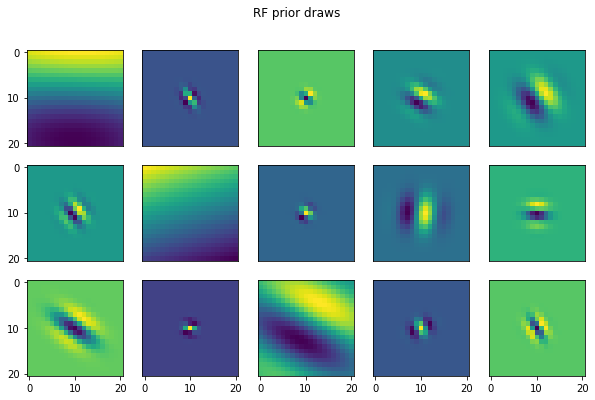

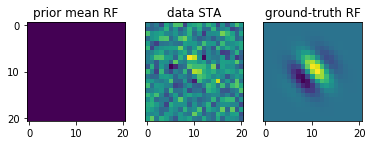

In [12]:
seed = 42

## simulation model

d = 21 # edge length of (quadratic) receptive field
parametrization = 'gabor' # ['full', 'gaussian', 'gabor']
len_kt = 2

params_ls = {'glm': ('bias',),
             'kernel': {'s' : ('gain', 'phase', 'vec_f', 'ratio', 'width'),
                        'l' : [],
                        't' : []}}

filter_shape = np.array((d,d,2))
m = maprf(filter_shape=filter_shape, 
          parametrization=parametrization,
          params_ls = params_ls,
          seed=seed, 
          dt = 0.025, 
          duration= 60 )

def create_prior(m):
    ## prior over simulation parameters
    prior = collections.OrderedDict()
    
    if 'bias' in m.params_ls['glm']:
        prior['λo'] = {'mu' : np.array([-0.57]), 'sigma' : np.array([np.sqrt(1.63)]) }
    if 'vec_A' in m.params_ls['kernel']['s']:
        prior['vec_A']  = {'mu' : np.zeros(2), 'sigma' : 1.0 * np.ones(2) }
    if 'gain' in m.params_ls['kernel']['s']:
        prior['float_A'] = {'mu' : np.array([0]), 'sigma' : np.array([1.])}  
    if 'phase' in m.params_ls['kernel']['s']:
        prior['logit_φ']  = {'mu' : np.array([0]), 'sigma' : np.array([1.78]) }    
    if 'vec_f' in m.params_ls['kernel']['s']:
        prior['vec_f']  = {'mu' : np.zeros(2), 'sigma' : 1.0 * np.ones(2) }
    if 'ratio' in m.params_ls['kernel']['s']:
        prior['log_γ']  = {'mu' : np.array([-0.098]), 'sigma' : np.array([0.256])}
    if 'width' in m.params_ls['kernel']['s']:
        prior['log_b']  = {'mu' : np.array([ 0.955]), 'sigma' : np.array([0.236])}
    if 'xo' in m.params_ls['kernel']['l']:
        prior['xo'] = {'mu' : np.array([0.]), 'sigma' : np.array([1/np.sqrt(.5)])}
    if 'yo' in m.params_ls['kernel']['l']:
        prior['yo'] = {'mu' : np.array([0.]), 'sigma' : np.array([1/np.sqrt(.5)])}    
        
    L = np.diag(np.concatenate([prior[i]['sigma'] for i in list(prior.keys())]))
    
    if 'value' in m.params_ls['kernel']['t']:
        ax_t = m.dt * np.arange(1,len_kt+1)
        Λ =  np.diag(ax_t / 0.075 * np.exp(1 - ax_t / 0.075))
        D = np.eye(ax_t.shape[0]) - np.eye(ax_t.shape[0], k=-1)
        F = np.dot(D, D.T)
        Σ = np.dot(Λ, np.linalg.inv(F).dot(Λ))
        prior['kt'] = {'mu': np.zeros_like(ax_t), 'sigma': np.linalg.inv(D).dot(Λ)}
        L = np.block([[L, np.zeros((L.shape[0], ax_t.size))], 
                      [np.zeros((ax_t.size, L.shape[1])), prior['kt']['sigma']]])
        
    mu  = np.concatenate([prior[i][ 'mu'  ] for i in prior.keys()])
    
    return dd.Gaussian(m=mu, S=L.T.dot(L), seed=seed)

p = create_prior(m)
s = maprfStats(n_summary=d*d)
g = dg.Default(model=m, prior=p, summary=s)

## training data and true parameters, data, statistics

params_dict_true = {'glm': {'binsize': m.dt,
                            'bias': 1.54546216004078},
                    'kernel': {'s': {'angle': 0.7,
                                     'freq': 1.2,
                                     'gain': 0.357703095858336,
                                     'phase': np.pi/4,
                                     'ratio': 1.,
                                     'width': 2.5},
                               'l': {'xo': 0.,
                                     'yo': 0.},
                               't': {'value': np.array([1., 0.])}}}
#                               't': {'tau': 0.015}}}
m.params_dict = params_dict_true
pars_true = m.read_params_buffer()

obs = m.gen_single()
obs_stats = s.calc([obs])

print('firing rate: ', np.sum(obs['data'])/m.duration)
print('total spikes: ', np.sum(obs['data']))


def plot_draws(m, p, name, x = 5, y = 3):
    fig, axes = plt.subplots(y, x, figsize=(x * 2, y * 2))
    
    for i in range(x):
        for j in range(y):
            ax = axes[j][i]
            if i > 0:
                ax.set_yticks([])
            if j < y - 1:
                ax.set_xticks([])
            ax.imshow(m.params_to_rf(p.gen().reshape(-1))[0], interpolation='None')
            
    fig.suptitle('RF {} draws'.format(name))
    plt.show()
    
    return fig, axes

plot_draws(m, p, "prior")

def plot_weird_stuff(m, p, posterior=None):
    if posterior is not None:
        fig, axes = plt.subplots(1, 5, figsize=(10,2))
    else:
        fig, axes = plt.subplots(1, 3, figsize=(6,2))
        
    axes[0].imshow(m.params_to_rf(p.mean)[0], interpolation='None')
    axes[0].set_title('prior mean RF')
    axes[1].imshow(obs_stats.reshape(d,d), interpolation='None')
    axes[1].set_title('data STA')
    axes[1].set_yticks([])
    axes[2].imshow(m.params_to_rf(pars_true)[0], interpolation='None')
    axes[2].set_title('ground-truth RF')
    axes[2].set_yticks([])
    
    if posterior is not None:
        axes[3].imshow(m.params_to_rf(posterior.calc_mean_and_cov()[0])[0], interpolation='None')
        axes[3].set_title('posterior mean RF')
        axes[3].set_yticks([])
        a_max = np.argmax(posterior.a)
        axes[4].imshow(m.params_to_rf(posterior.xs[a_max].m)[0], interpolation='None')
        axes[4].set_title('posterior mode RF')
        axes[4].set_yticks([])

    plt.show()
    
    return fig, axes

plot_weird_stuff(m, p);

In [ ]:
n_hiddens_cdelfi=(50,50)
n_filters_cdelfi=(24,24)

n_train=3000
epochs=100
minibatch=50
n_rounds=3
n_components=1

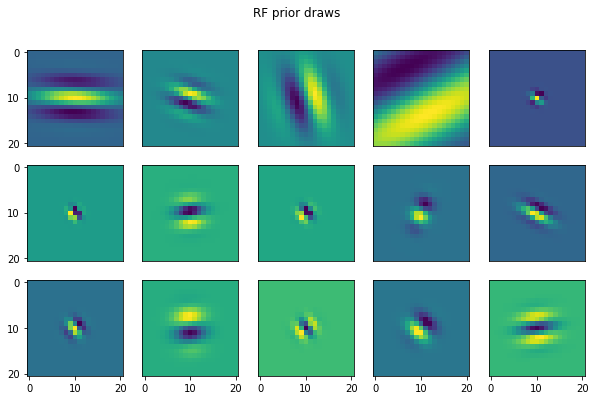

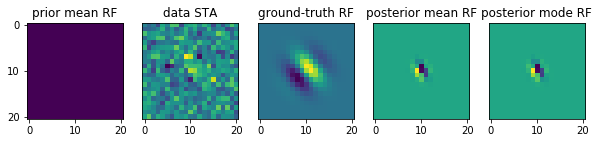

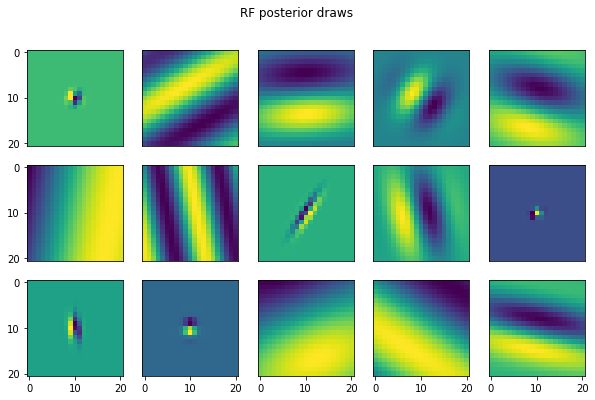

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/usr/local/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/usr/local/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


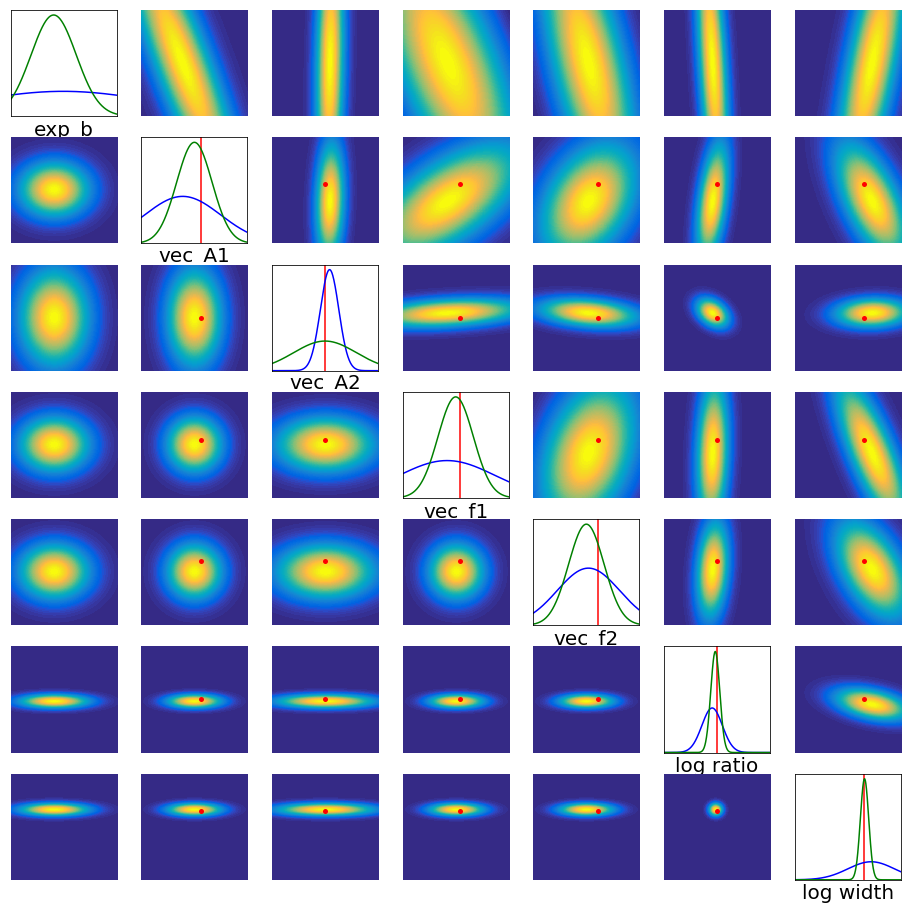

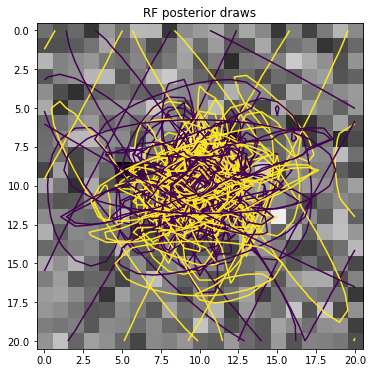

In [14]:
inf = infer.CDELFI(generator=g, obs=obs_stats, prior_norm=False, pilot_samples=None, seed=seed,
                 n_components=n_components, n_hiddens=n_hiddens, n_filters=n_filters, n_inputs = (1,d,d))

logs = inf.run(n_train=n_train, epochs=epochs, minibatch=minibatch, n_rounds=n_rounds)

posterior = inf.predict(obs_stats)
posterior.ndim = posterior.xs[0].ndim

plot_draws(m, p, "prior")
plot_weird_stuff(m, p, posterior)
plot_draws(m, posterior, "posterior")

# all pairwise marginals of fitted posterior
fig, _ = plot_pdf(posterior, pdf2=p, lims=[-3,3], gt=pars_true.reshape(-1), figsize=(16,16), 
                  labels_params=['exp_b', 'vec_A1', 'vec_A2', 'vec_f1', 'vec_f2', 'log ratio', 'log width'])
fig.savefig('res.pdf')

def plot_posterior_contours(m, posterior):
    plt.figure(figsize=(6,6))
    plt.imshow(obs_stats.reshape(d,d), interpolation='None', cmap='gray')
    for i in range(100):
        rfm = m.params_to_rf(posterior.gen().reshape(-1))[0]
        plt.contour(rfm, levels=[-0.1, 0.1])
        plt.hold(True)
    plt.title('RF posterior draws')
    plt.show()

round  0


/usr/local/lib/python3.6/site-packages/matplotlib/axes/_base.py:2917: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.232217843725, right=0.232217843725
  'left=%s, right=%s') % (left, right))
/usr/local/lib/python3.6/site-packages/matplotlib/axes/_base.py:2917: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=-0.0122467728469, right=-0.0122467728469
  'left=%s, right=%s') % (left, right))
/usr/local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3193: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.232217843725, top=0.232217843725
  'bottom=%s, top=%s') % (bottom, top))
/usr/local/lib/python3.6/site-packages/matplotlib/axes/_base.py:2917: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=-1.59

posterior mean: [-0.03391934 -0.66332285  0.2569643  -0.49049676  0.11761071 -0.27560183
  1.3307832 ]
sampled mean: [-0.45435053 -0.0352389  -0.32351233 -0.0580481  -0.25443178 -0.04960964
  0.90660127]


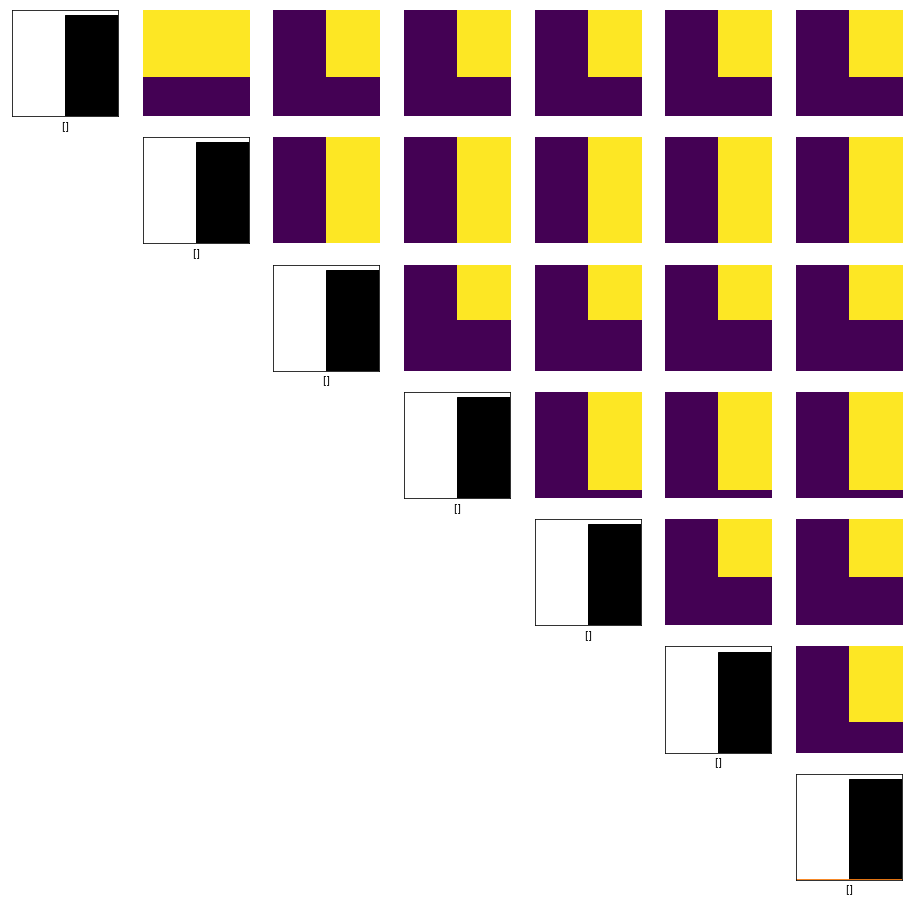

round  1


/usr/local/lib/python3.6/site-packages/matplotlib/axes/_base.py:2917: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.263327898119, right=0.263327898119
  'left=%s, right=%s') % (left, right))
/usr/local/lib/python3.6/site-packages/matplotlib/axes/_base.py:2917: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.257686610737, right=0.257686610737
  'left=%s, right=%s') % (left, right))
/usr/local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3193: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.263327898119, top=0.263327898119
  'bottom=%s, top=%s') % (bottom, top))
/usr/local/lib/python3.6/site-packages/matplotlib/axes/_base.py:2917: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0251085

posterior mean: [-0.03391934 -0.66332285  0.2569643  -0.49049676  0.11761071 -0.27560183
  1.3307832 ]
sampled mean: [-0.42757503 -0.26534032  0.20393656 -1.20914421  0.06527154 -0.18558824
  1.83093348]


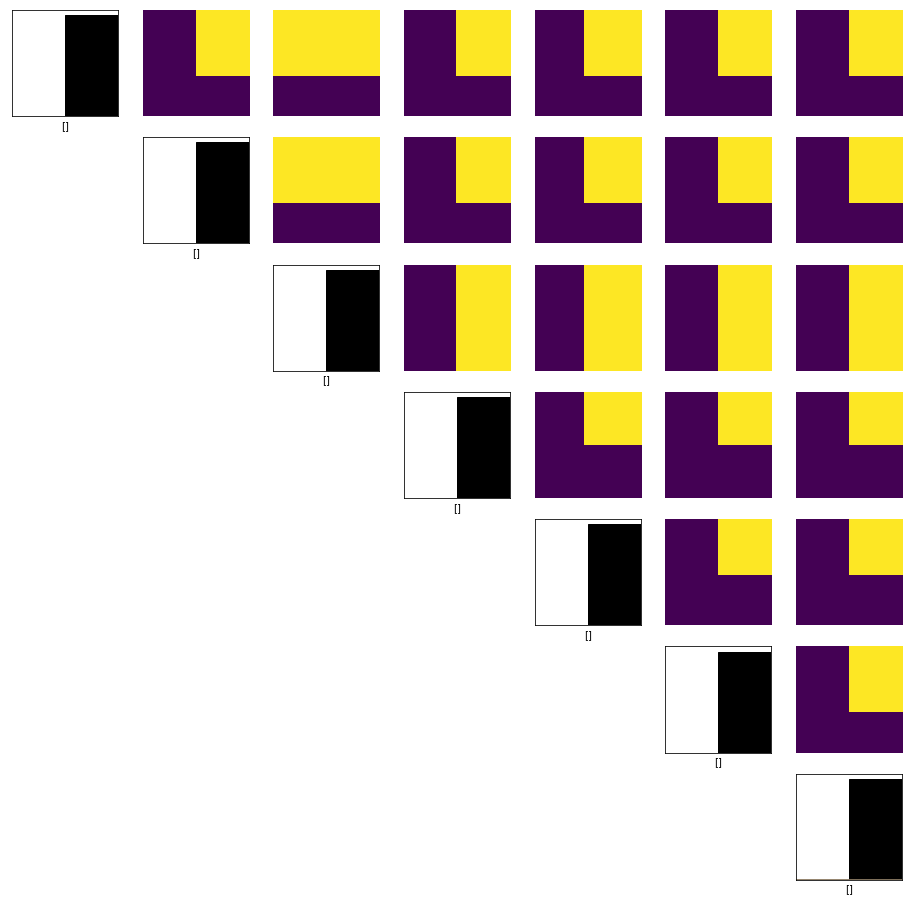

round  2


ValueError: zero-size array to reduction operation minimum which has no identity

In [16]:
for r in range(n_rounds):
    print('round ', str(r))
    parameters =  logs[1][r][0] * inf.params_std + inf.params_mean
    samples = logs[1][r][1] * inf.stats_std + inf.stats_mean
    
    x_dists = np.sum( (samples[:,0,:,:] - obs_stats.reshape(1, d,d))**2, axis=(1,2))
    thresh = np.sort(x_dists)[x_dists.size//20]
    idx_0 = np.where(x_dists < thresh)[0]
    
    m_,S_ = parameters.mean(axis=0), np.cov(parameters.T)
    posterior_sampled = dd.Gaussian(m=m_, S=S_)

    # all pairwise marginals of fitted posterior
    plot_pdf(posterior, lims=[-5,5], figsize=(16,16), samples=parameters[idx_0,:].T);

    print('posterior mean:', posterior.xs[0].m)
    print('sampled mean:', posterior_sampled.m)
    plt.plot(posterior.xs[0].m)
    plt.plot(posterior_sampled.m)
    plt.show()

In [ ]:
# second stage: multi-component posterior

n_hiddens=(50,50)
n_filters=(24,24,24)

n_train=5000
epochs=100
minibatch=50
n_rounds=2
n_components=4

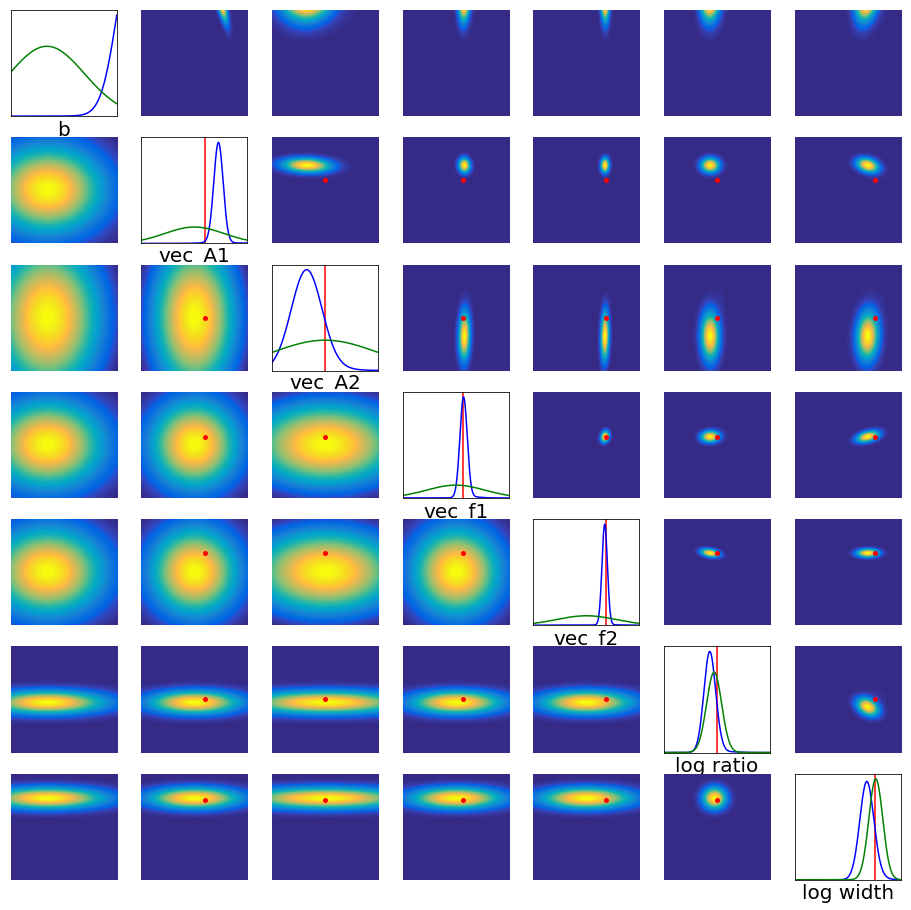

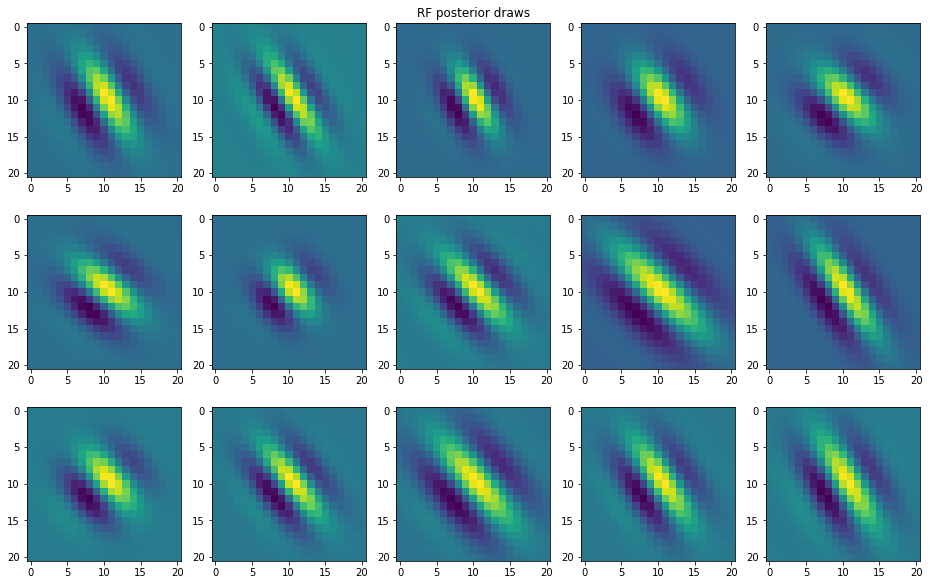

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/usr/local/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/usr/local/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


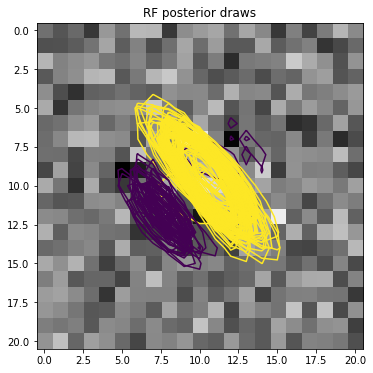

In [6]:

m_, S_ = posterior.calc_mean_and_cov()

#g_ = dg.Default(model=m, prior=dd.Gaussian(m=m_, S=S_), summary=s)

# generate new inference object, including brand-new network with new number of components
inf = infer.SNPE(generator=g, obs=obs_stats, prior_norm=False, pilot_samples=None, seed=seed, reg_lambda=0,
                 n_components=n_components, n_hiddens=n_hiddens, n_filters=n_filters, n_inputs = (1,d,d), svi=False)

# immediately hand over proposal distribution (will sample from proposal instead of prior from first round!)
inf.generator.proposal=dd.Gaussian(m=m_, S=S_)

log2s = inf.run(n_train=n_train, epochs=epochs, minibatch=minibatch, n_rounds=n_rounds)
posterior2 = inf.predict(obs_stats)
posterior2.ndim = posterior2.xs[0].ndim
fig, _ = plot_pdf(posterior2, pdf2=g.prior, lims=[-1.8,1.8], gt=pars_true.reshape(-1), figsize=(16,16), 
                  labels_params=['b', 'vec_A1', 'vec_A2', 'vec_f1', 'vec_f2', 'log ratio', 'log width', 'xo', 'yo'])
#fig.savefig('SNPE_posterior_2modes.pdf')

plot_draws(m, posterior, "posterior")

# bunch of example prior draws
plt.figure(figsize=(6,6))
plt.imshow(obs_stats.reshape(d,d), interpolation='None', cmap='gray')
for i in range(100):
    rfm = m.params_to_rf(posterior2.gen().reshape(-1))[0]
    plt.contour(rfm, levels=[-0.1, 0.1])
    #print(rfm.min(), rfm.max())
    plt.hold(True)
plt.title('RF posterior draws')
plt.show()